In [1]:
import os
import tensorflow as tf
import numpy as np
from keras.applications import ResNet50
from efficientnet.tfkeras import EfficientNetB4
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import seaborn as sns
from IPython.display import Image
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_path = "./wildfire-dataset/train"
valid_path = "./wildfire-dataset/valid"
test_path = "./wildfire-dataset/test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [5]:
def display_images_from_generator(generator, num_images=5):
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(num_images * 3, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_batch[i])
        label = "1: wildfire" if y_batch[i] > 0.5 else "0: nowildfire"
        plt.title(label, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

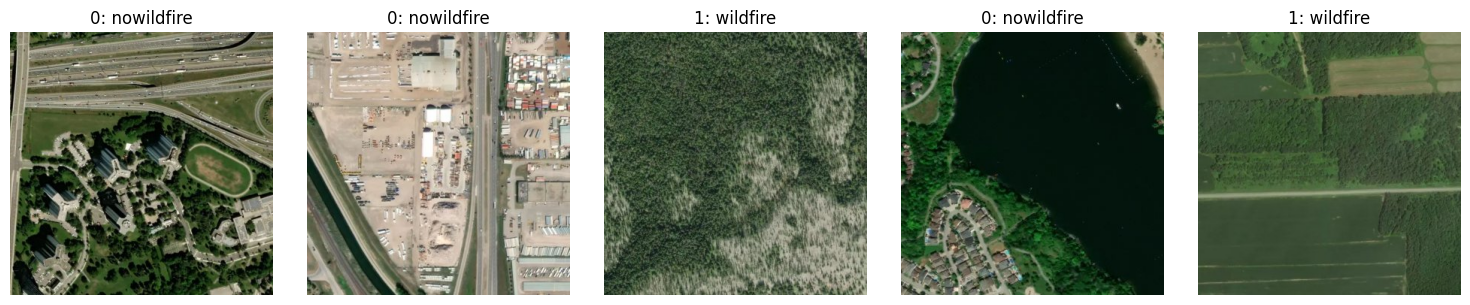

In [6]:
display_images_from_generator(train_generator)

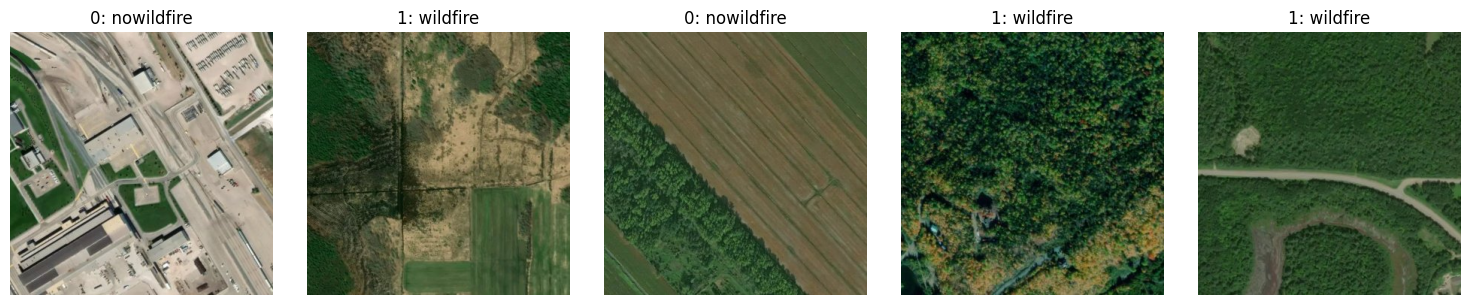

In [7]:
display_images_from_generator(valid_generator)

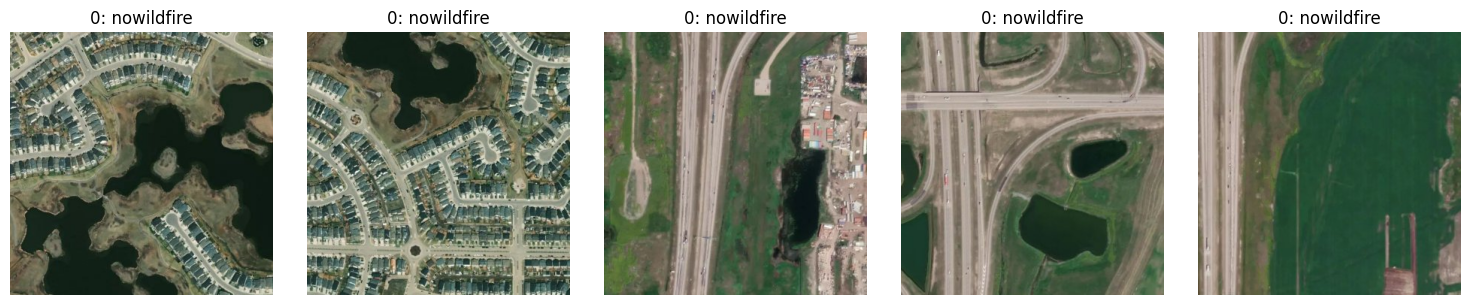

In [8]:
display_images_from_generator(test_generator)

In [9]:
def resnet50(input_shape=(350, 350, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x) 

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.name = 'ResNet50'

    return model

In [10]:
model=resnet50()

In [11]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350, 350,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 356, 356,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 175, 175,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 175, 175,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 175, 175,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 177, 177,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 88, 88,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 88, 88,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 88, 88,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 88, 88,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 88, 88,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 88, 88,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 88, 88,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 88, 88,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 88, 88,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 88, 88,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 88, 88,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 3,153,921 (12.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

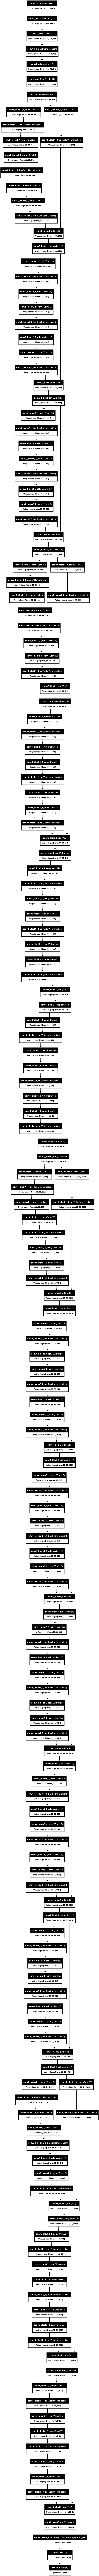

In [12]:
plot_model(model, to_file=f'{model.name}_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)
Image(filename=f'{model.name}_model.png')

In [13]:
%%time
checkpointer = ModelCheckpoint(f'{model.name}.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=valid_generator,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8574 - loss: 0.3748
Epoch 1: val_loss improved from inf to 0.54970, saving model to ResNet50.weights.h5
946/946 ━━━━━━━━━━━━━━━━━━━━ 787s 826ms/step - accuracy: 0.8574 - loss: 0.3747 - val_accuracy: 0.7324 - val_loss: 0.5497
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9038 - loss: 0.2473
Epoch 2: val_loss did not improve from 0.54970
946/946 ━━━━━━━━━━━━━━━━━━━━ 808s 853ms/step - accuracy: 0.9038 - loss: 0.2473 - val_accuracy: 0.4484 - val_loss: 1.5135
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9118 - loss: 0.2269
Epoch 3: val_loss improved from 0.54970 to 0.20246, saving model to ResNet50.weights.h5
946/946 ━━━━━━━━━━━━━━━━━━━━ 837s 885ms/step - accuracy: 0.9118 - loss: 0.2269 - val_accuracy: 0.9241 - val_loss: 0.2025
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9159 - loss: 0.2237
Epoch 4: val_loss did not improve from 0.20246
946/946 ━━━━━━━━━━━

In [14]:
def display_images_with_predictions_from_generator(generator, model, num_wildfire=2, num_nowildfire=2):
    wildfire_pool = []
    nowildfire_pool = []

    while len(wildfire_pool) < num_wildfire or len(nowildfire_pool) < num_nowildfire:
        x_batch, y_batch = next(generator)
        for i in range(len(y_batch)):
            if y_batch[i] > 0.5:  # Wildfire
                wildfire_pool.append((x_batch[i], y_batch[i]))
            else:  # No Wildfire
                nowildfire_pool.append((x_batch[i], y_batch[i]))

    np.random.seed(10)
    selected_wildfire = np.random.choice(range(len(wildfire_pool)), size=num_wildfire, replace=False)
    selected_nowildfire = np.random.choice(range(len(nowildfire_pool)), size=num_nowildfire, replace=False)

    selected_images = [wildfire_pool[i][0] for i in selected_wildfire] + [nowildfire_pool[i][0] for i in selected_nowildfire]
    selected_labels = [wildfire_pool[i][1] for i in selected_wildfire] + [nowildfire_pool[i][1] for i in selected_nowildfire]

    predictions = model.predict(np.array(selected_images)).flatten()

    plt.figure(figsize=(len(selected_images) * 3, 3))
    for i in range(len(selected_images)):
        plt.subplot(1, len(selected_images), i + 1)
        plt.imshow(selected_images[i])
        true_label = "Wildfire" if selected_labels[i] > 0.5 else "No Wildfire"
        predicted_label = "Wildfire" if predictions[i] > 0.5 else "No Wildfire"
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


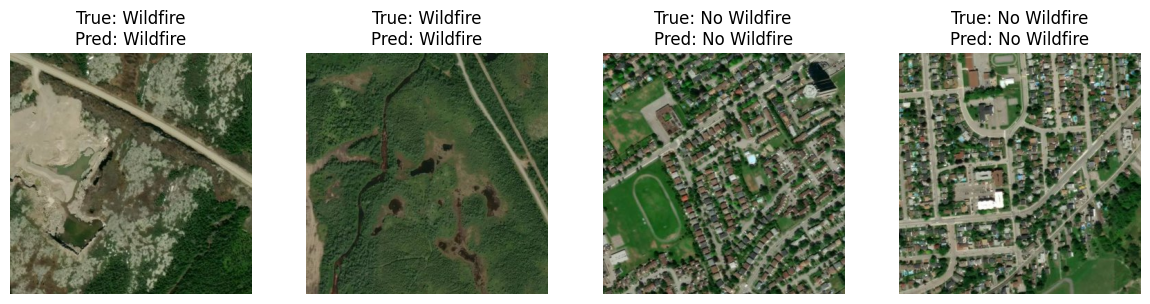

In [15]:
display_images_with_predictions_from_generator(test_generator, model)

In [16]:
def plot_confusion_matrix_and_metrics(generator, model):
    label_names = ['No Wildfire', 'Wildfire']
    # Step 1: Calculate metrics and prepare the data
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Confusion matrix visualization
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=45)
    plt.yticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=45)
    plt.show()

    # Classification Report in text
    report_text = classification_report(y_true, y_pred, target_names=label_names)
    print(report_text)
    
    # Print F1 score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")

    # Print accuracy in percentage
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

197/197 ━━━━━━━━━━━━━━━━━━━━ 137s 685ms/step


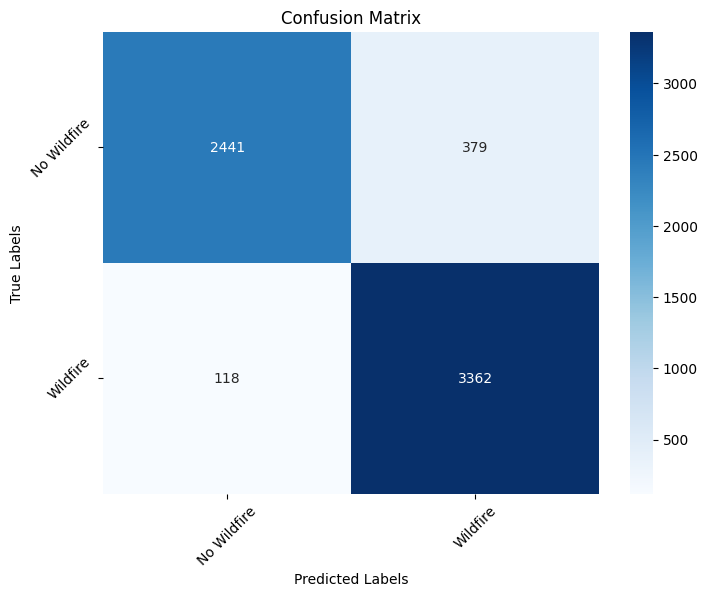

              precision    recall  f1-score   support

 No Wildfire       0.95      0.87      0.91      2820
    Wildfire       0.90      0.97      0.93      3480

    accuracy                           0.92      6300
   macro avg       0.93      0.92      0.92      6300
weighted avg       0.92      0.92      0.92      6300

F1 Score: 0.93
Accuracy: 92.11%


In [17]:
plot_confusion_matrix_and_metrics(test_generator, model)

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model.name}_training_history.png', dpi=300)
    plt.show()

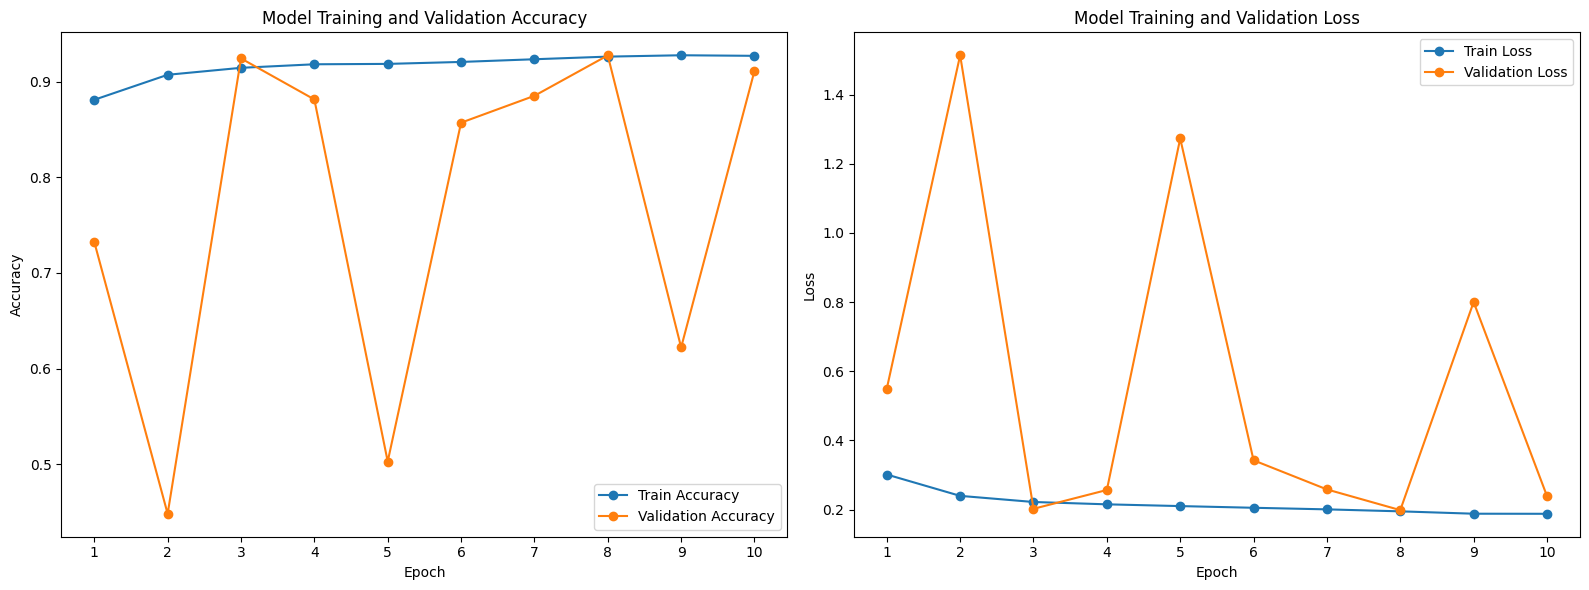

In [19]:
plot_training_history(history)